# Solutions to the machine-Learning tutorial for classification

## Objective
1. Predict diagnostic label from functional connectome
2. Predict MRI acquisition site from functional connectome

## Dataset
[ABIDE (Autism)](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_abide_pcp.html)

## Preprocessing
1. Generate region-to-region connectivity matrix (i.e. connectome) from functional timeseries data
    - ROIs are defined based on [harvard_oxford atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_harvard_oxford.html) or [AAL atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_aal.html)
2. Apply dimensionality reduction (Optional)

## Model 
1. Logistic regression
2. Random Forest

## Cross-validation
2. shuffle-split

## post-hoc analysis
Compare model performance for predicting Dx labels vs. MRI acquisition site


# Let's begin! 
### First we import some useful python libraries...

In [3]:
## Imports
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Download data

In [5]:
n_subjects = 100
parcel = "rois_ho"  # 'rois_ho' or 'rois_aal
data = datasets.fetch_abide_pcp(n_subjects=n_subjects, derivatives=[parcel], data_dir="./")

## Phenotypes and Demographics

In [3]:
pheno = pd.DataFrame(data["phenotypic"]).drop(columns=["i", "Unnamed: 0"])
pheno.head()

,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,50003,2,50003,b'PITT',b'Pitt_0050003',1,1,24.45,1,b'R',...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',1
1,50004,3,50004,b'PITT',b'Pitt_0050004',1,1,19.09,1,b'R',...,b'',b'OK',b'',b'OK',b'',b'OK',b'',b'OK',b'',1
2,50005,4,50005,b'PITT',b'Pitt_0050005',1,1,13.73,2,b'R',...,b'',b'OK',b'',b'maybe',b'ic-parietal-cerebellum',b'OK',b'',b'OK',b'',0
3,50006,5,50006,b'PITT',b'Pitt_0050006',1,1,13.37,1,b'L',...,b'',b'OK',b'',b'maybe',b'ic-parietal slight',b'OK',b'',b'OK',b'',1
4,50007,6,50007,b'PITT',b'Pitt_0050007',1,1,17.78,1,b'R',...,b'',b'OK',b'',b'maybe',b'ic-cerebellum_temporal_lob',b'OK',b'',b'OK',b'',1


In [4]:
site_counts = pheno["SITE_ID"].value_counts()
dx_counts = pheno["DX_GROUP"].value_counts()

print(f"Dx count:\n{dx_counts}\n\nScanning site_counts:\n{site_counts}")

Dx count:
2    50
1    50
Name: DX_GROUP, dtype: int64

Scanning site_counts:
b'PITT'    50
b'OLIN'    28
b'OHSU'    22
Name: SITE_ID, dtype: int64


## MRI features

### These are stored in a list, where each list element is a subject-specific feature matrix
### Subject specific feature matrix: timepoints x ROIs
### ROIs are defined based on [harvard_oxford atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_harvard_oxford.html) or [AAL atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_aal.html)

In [5]:
features = data[parcel]

print(f"Number of samples: {len(features)}")

subject_feature_shape = features[0].shape

print(f"subject_feature_shape: {subject_feature_shape}")

Number of samples: 100
subject_feature_shape: (196, 111)


## Let's see how the atlas looks like

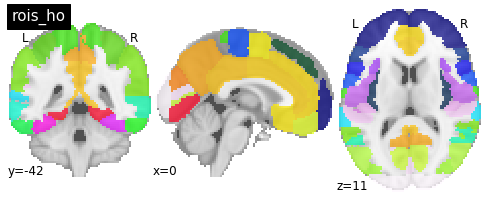

In [6]:
from nilearn import plotting

if parcel == "rois_ho":
    atlas = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
else:
    atlas = datasets.fetch_atlas_aal()

plotting.plot_roi(atlas.maps, draw_cross=False, title=parcel)

## And the subject-specific feature matrix

Text(0.5, 1, 'Functional data timeseries')

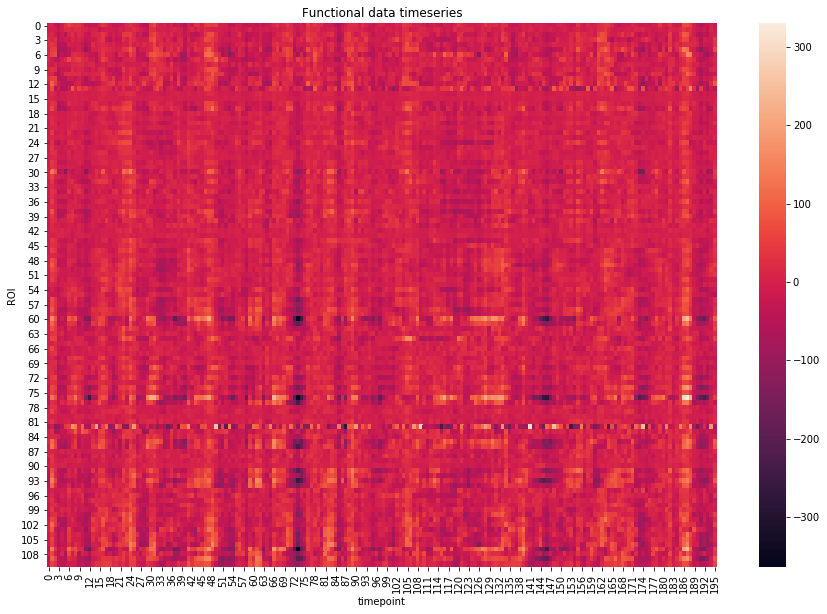

In [7]:
f, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(features[0].T, ax=ax)
g.set_xlabel("timepoint")
g.set_ylabel("ROI")
g.set_title("Functional data timeseries")

## Preprocessing / feature engineering

### Commonly functional (timeseries) neuroimaging data is represented as functional connectome aka network ake graph. 

Shape connectome: (111, 111)


Text(0.5, 1, 'Connectome')

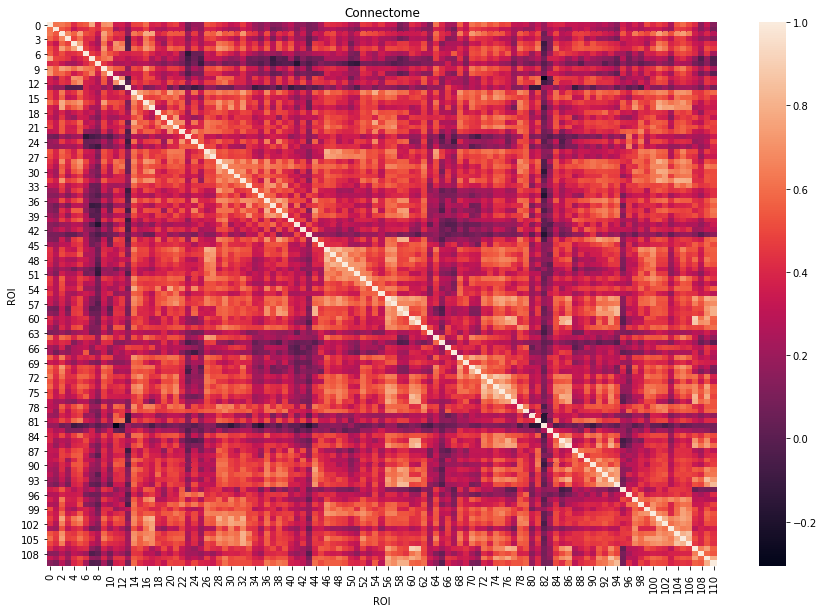

In [8]:
connectome_matrix = ConnectivityMeasure(kind="correlation")
connectome_matrix = connectome_matrix.fit_transform([features[0]])[0]
print(f"Shape connectome: {connectome_matrix.shape}")

f, ax = plt.subplots(figsize=(15, 10))
g = sns.heatmap(connectome_matrix, ax=ax)
g.set_xlabel("ROI")
g.set_ylabel("ROI")
g.set_title("Connectome")

In [9]:
# Extract lower (or upper) triangle entrees (excluding diagonal)
tril_idx = np.tril_indices(len(connectome_matrix), k=-1)
features_flat = connectome_matrix[tril_idx]
print(f"Number of features per subject: {len(features_flat)}")

Number of features per subject: 6105


## Now do this for all subjects!

In [10]:
# defs are definitely useful!


def extract_connectome_features(func_data, measure):
    """A function to calculate connnectome based on timeseries data and similarity measure"""
    connectome_matrix = measure.fit_transform([func_data])[0]
    tril_idx = np.tril_indices(len(connectome_matrix), k=-1)
    flat_features = connectome_matrix[tril_idx]

    return flat_features

## Note

here we are pre-processing each image independently i.e. not using any group-level information for scaling / normalization / feature transformation (e.g. PCA). Therefore there is no "double dipping" or leakage of information from a test set. This sort of independent image pre-processing, we can do on entire dataset without creating train-test splits first and then defining feature-set on the training data only. 

In [11]:
correlation_measure = ConnectivityMeasure(kind="correlation")

flat_features_list = []
for func_data in features:
    flat_features = extract_connectome_features(func_data, correlation_measure)
    flat_features_list.append(flat_features)

print(f"Length of flat_features_list {len(flat_features_list)}")

Length of flat_features_list 100


## Input data matrix (n_samples, n_features)

In [12]:
X = np.array(flat_features_list)

print(f"Input data (X) shape: {X.shape}")

# Memory intensive #

# g = sns.heatmap(flat_features_array)
# g.set_xlabel('Connection strength')
# g.set_ylabel('ROI')
# g.set_title('Connectome')

Input data (X) shape: (100, 6105)


## Output labels (y): Diagnosis


In [13]:
from sklearn import preprocessing

outcome = "DX_GROUP"
y = pheno[outcome]
y_counts = y.value_counts()

print(f"Unique output clasess:\n{y_counts}")

# Encode labels to integer categories
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

Unique output clasess:
2    50
1    50
Name: DX_GROUP, dtype: int64


## Okay now we have our input data (X) and output data (y) in the following format
<img src="./QLS_ML_terminology.png" alt="terms" width="800"/>


## Create train-test split
- 80/20 ratio
- Stratify 

In [14]:
from sklearn.model_selection import train_test_split

test_subset_fraction = 0.2  #
stratification = y

X_train, X_test, y_train, y_test = train_test_split(
    X,  # input features
    y,  # output labels
    test_size=test_subset_fraction,
    shuffle=True,  # shuffle dataset
    # before splitting
    stratify=stratification,
    random_state=123,  # same shuffle each time
)

# print the size of our training and test groups
print("training:", len(X_train), "testing:", len(X_test))

training: 80 testing: 20


## Okay finally, let's train your first model!

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model = "LR"  # 'LR' or 'RF'

if model == "RF":
    clf = RandomForestClassifier(max_depth=3, class_weight="balanced", random_state=0)
elif model == "LR":
    clf = LogisticRegression(
        penalty="l1", C=1, class_weight="balanced", solver="saga", random_state=0
    )
else:
    print(f"Unknown model: {model}")

print(f"Using model: {model}")

clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
print(f"train acc: {train_acc:.3f}")

Using model: LR
train acc: 0.825


/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Evaluate on test set
- accuracy
- confusion_matrix
- precision_recall_fscore 

In [16]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

test_acc = clf.score(X_test, y_test)
print(f"test acc: {test_acc:.3f}")

test_cm = confusion_matrix(y_test, y_pred)

test acc: 0.600


### Note the difference between train and test accuracy. If the difference is large, we are most likely overfitting the model to the train set. 

#### Things to try:
- Increase regularization
- Reduce dimensionality of X

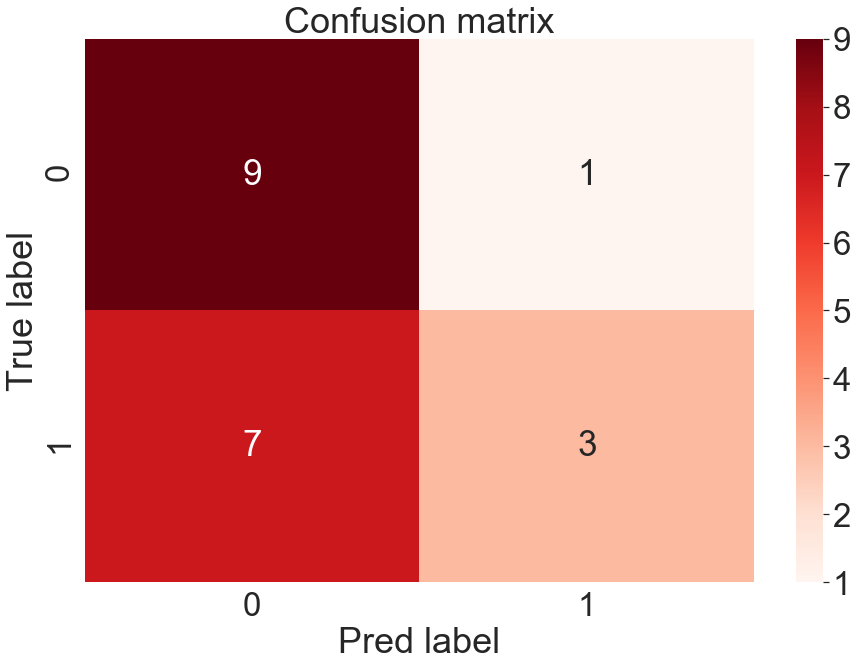

In [17]:
sns.set(font_scale=3)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(15, 10))

    g = sns.heatmap(test_cm, ax=ax, annot=True, annot_kws={"fontsize": 35}, cmap="Reds")
    g.set_title("Confusion matrix")
    g.set_ylabel("True label")
    g.set_xlabel("Pred label")

In [18]:
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

print(
    f"model: {model}, outcome: {outcome}\n Acc:{test_acc:.2f}, precision: {p:.2f}, recall: {r:.2f}, f1: {f1:.2f}"
)

model: LR, outcome: DX_GROUP
 Acc:0.60, precision: 0.66, recall: 0.60, f1: 0.56


## Now let's predict scanning site!

In [19]:
outcome = "SITE_ID"
y = pheno[outcome]
y_counts = y.value_counts()

print(f"Unique output clasess:\n{y_counts}")

# Encode labels to integer categories
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

Unique output clasess:
b'PITT'    50
b'OLIN'    28
b'OHSU'    22
Name: SITE_ID, dtype: int64


## Create train-test split
- 80/20 ratio
- Stratify 

In [20]:
from sklearn.model_selection import train_test_split

test_subset_fraction = 0.2  #
stratification = y

X_train, X_test, y_train, y_test = train_test_split(
    X,  # input features
    y,  # output labels
    test_size=test_subset_fraction,
    shuffle=True,  # shuffle dataset
    # before splitting
    stratify=stratification,
    random_state=123,  # same shuffle each time
)

# print the size of our training and test groups
print("training:", len(X_train), "testing:", len(X_test))

training: 80 testing: 20


## Fit the model

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model = "LR"  # 'LR' or 'RF'

if model == "RF":
    clf = RandomForestClassifier(max_depth=3, class_weight="balanced", random_state=0)
elif model == "LR":
    clf = LogisticRegression(
        penalty="l2", C=1, class_weight="balanced", solver="saga", random_state=0
    )
else:
    print(f"Unknown model: {model}")

print(f"Using model: {model}")

clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
print(f"train acc: {train_acc:.3f}")

Using model: LR
train acc: 1.000


/home/nikhil/projects/green_comp_neuro/green_compute/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Evaluate on test set
- accuracy
- confusion_matrix
- precision_recall_fscore 

In [22]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

test_acc = clf.score(X_test, y_test)
print(f"test acc: {test_acc:.3f}")

test_cm = confusion_matrix(y_test, y_pred)

test acc: 0.800


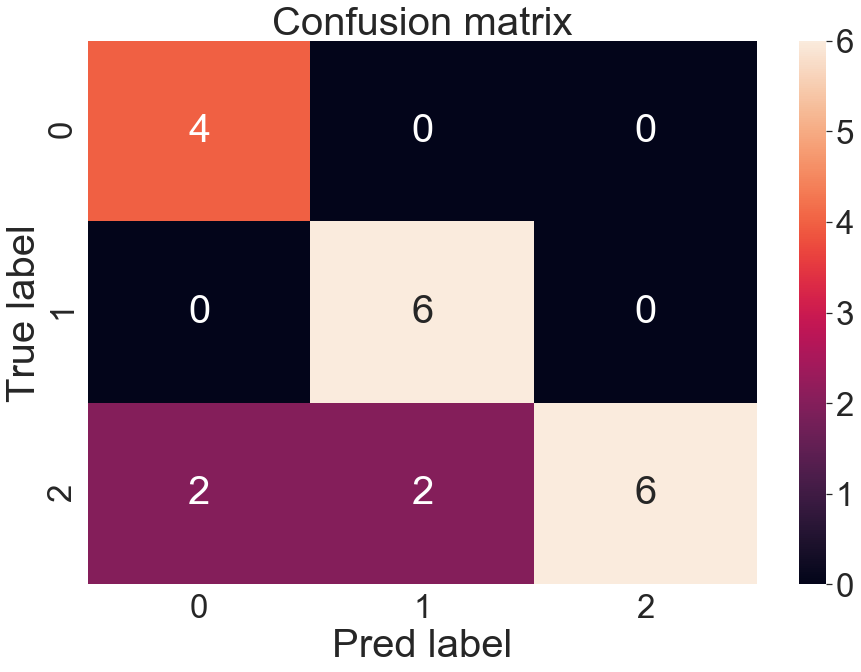

In [23]:
sns.set(font_scale=3)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(15, 10))
    g = sns.heatmap(test_cm, annot=True, ax=ax, annot_kws={"fontsize": 40})
    g.set_title("Confusion matrix", fontsize=40)
    g.set_ylabel("True label", fontsize=40)
    g.set_xlabel("Pred label", fontsize=40)

In [24]:
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

print(
    f"model: {model}, outcome: {outcome}\n Acc:{test_acc:.2f}, precision: {p:.2f}, recall: {r:.2f}, f1: {f1:.2f}"
)

model: LR, outcome: SITE_ID
 Acc:0.80, precision: 0.86, recall: 0.80, f1: 0.79
